<a href="https://colab.research.google.com/github/thrinnadhh/Netflix_movie_recommendation_system/blob/main/NMRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d netflix-inc/netflix-prize-data

 97% 663M/683M [00:04<00:00, 194MB/s]
100% 683M/683M [00:04<00:00, 175MB/s]


In [ ]:
from zipfile import ZipFile
dataset="/content/netflix-prize-data.zip"
with ZipFile(dataset,"r") as zip:
  zip.extractall()
print("The zip got extracted")

The zip got extracted


Importing the dependencies

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import random
import os
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
##combining the dataset
start_time=datetime.now()
if not os.path.isfile('data.csv'):
  data=open('data.csv',mode='w')
  files=["/content/combined_data_1.txt","/content/combined_data_2.txt","/content/combined_data_3.txt","/content/combined_data_4.txt"]
  row=[]
  for file in files:
    with open(file) as f:
      print("Reading the rating from the file",file)
      for line in f:
        line=line.strip()
        if line.endswith(":"):
          movie_id=line.replace(":","")
        else:
          row=[x for x in line.split(",")]
          row.insert(0,movie_id)
          data.write(",".join(row))
          data.write("\n")
      print("Done")
  data.close()
print("The data file got closed")
print("The time taken for the process is:",datetime.now()-start_time)




Reading the rating from the file /content/combined_data_1.txt
Done
Reading the rating from the file /content/combined_data_2.txt
Done
Reading the rating from the file /content/combined_data_3.txt
Done
Reading the rating from the file /content/combined_data_4.txt
Done
The data file got closed
The time taken for the process is: 0:02:37.689379


In [ ]:
print("Creating the dataframe from the dataset")
df=pd.read_csv('/content/data.csv',sep=",",names=['movie','user','rating','date'])
df.date=pd.to_datetime(df.date)



Creating the dataframe from the dataset


In [ ]:
df.head()

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [ ]:
print('sorting values by date')
df.sort_values(by='date',inplace=True)
print("The values got sorted by date")

sorting values by date


In [ ]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [ ]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

From this we can see that 75 and 50 percent of rating are on 4.

Mean is 3.6 which indicates that netflix is providing the good content

Checking for the nan values

In [ ]:
print("The sum of null values are:",sum(df.isnull().any()))

The sum of null values are: 0


In [ ]:
##checking for the duplicates
dup_bool=df.duplicated(['movie','user','rating'])
print(sum(dup_bool))

0


In [ ]:
df.shape

(100480507, 4)

In [ ]:
##Basic stats
print("Total number of training data",df.shape[0])
print("*"*50)
print("Total number of unique user",len(np.unique(df.user)))
print('Total number of unique movie',len(np.unique(df.movie)))

Total number of training data 100480507
**************************************************
Total number of unique user 480189
Total number of unique movie 17770


In [ ]:
##Splitting the data into train and test data
starttime=datetime.now()
if not os.path.isfile('/content/train.csv'):
  df.iloc[:int(df.shape[0]*0.80)].to_csv('train.csv',index=False)
if not os.path.isfile('/content/test.csv'):
  df.iloc[int(df.shape[0]*0.80):].to_csv('test.csv',index=False)
print("The time it taken to run this cell is",datetime.now()-starttime)


The time it taken to run this cell is 0:11:04.296792


In [ ]:
df=pd.read_csv('/content/train.csv')

In [ ]:
df.head()

,movie,user,rating,date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11
3,8651,510180,2,1999-11-11
4,14660,510180,2,1999-11-11


In [ ]:
df.tail()

,movie,user,rating,date
80384400,12074,2033618,4,2005-08-08
80384401,862,1797061,3,2005-08-08
80384402,10986,1498715,5,2005-08-08
80384403,14861,500016,4,2005-08-08
80384404,5926,1044015,5,2005-08-08


In [ ]:
df=pd.read_csv('/content/test.csv')

In [ ]:
df.head()

,movie,user,rating,date
0,5926,2294429,2,2005-08-08
1,10158,1743373,4,2005-08-08
2,17064,381625,5,2005-08-08
3,1443,1252933,5,2005-08-08
4,1201,1434500,4,2005-08-08


In [ ]:
train_df=pd.read_csv("/content/train.csv",parse_dates=['date'])

##Basic stats
print("The training data is of size:",train_df.shape[0])
print("#"*50)
print("The no of unique user in training data is:",len(np.unique(train_df.user)))
print("The no of unique movie in training data is:",len(np.unique(train_df.movie)))
print("The starting and ending date of the training data is:",train_df.date[0],train_df.date[len(train_df)-1])

The training data is of size: 80384405
##################################################
The no of unique user in training data is: 405041
The no of unique movie in training data is: 17424
The starting and ending date of the training data is: 1999-11-11 00:00:00 2005-08-08 00:00:00


In [ ]:
test_df=pd.read_csv("/content/test.csv",parse_dates=['date'])

print("The testing data is of size:",test_df.shape[0])
print("#"*50)
print("The number of unique user in testing data is:",len(np.unique(test_df.user)))
print("The number of unique movie in testing data is:",len(np.unique(test_df.user)))
print("The starting and ending date of the testing data is:",test_df.date[0],test_df.date[len(test_df)-1])

The testing data is of size: 20096102
##################################################
The number of unique user in testing data is: 349312
The number of unique movie in testing data is: 349312
The starting and ending date of the testing data is: 2005-08-08 00:00:00 2005-12-31 00:00:00


In [ ]:
def human(item,units="m"):
  units=units.lower()
  if units=="k":
    return str(item/10**3)+"K"
  elif units=="m":
    return str(item/10**6)+"M"
  elif units=="b":
    return str(item/10**9)+"b"
  

Text(0.5, 0, 'No rating in dataset')

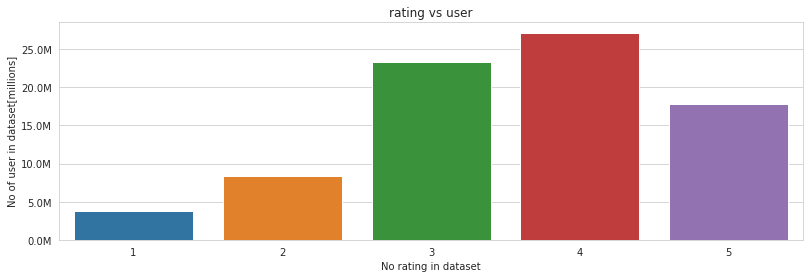

In [ ]:
fig,ax=plt.subplots(figsize=plt.figaspect(0.3))
plt.title("rating vs user")

sns.countplot(x=train_df.rating)
ax.set_yticklabels([human(items,'m') for items in ax.get_yticks()])
ax.set_ylabel("No of user in dataset[millions]")
ax.set_xlabel("No rating in dataset")

From this we can observe that the average rating is good also almost 28 million users gave the rating of 4 which shows the netflix provides the good content.

In [ ]:
##Adding the weekday column into the dataframe
train_df['week_days']=train_df.date.dt.day_name()
train_df.head()

,movie,user,rating,date,week_days
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


In [ ]:
train_df.tail()

,movie,user,rating,date,week_days
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


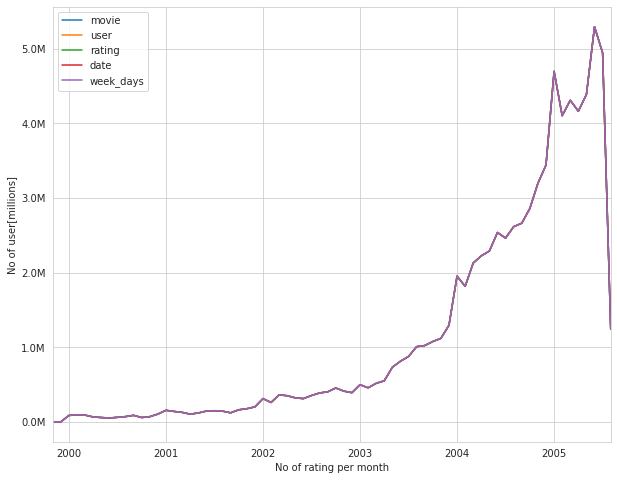

In [ ]:
##Number of rattings per month
ax=train_df.resample("m",on='date').count().plot(figsize=(10,8))
ax.set_xlabel('No of rating per month')
ax.set_ylabel('No of user[millions]')
ax.set_yticklabels([human(items,'m') for items in ax.get_yticks()])
plt.show()



From this we can see that netflix got higest rating in 2003 to 2005 means it got more no of user in this period [getting popular this time period]

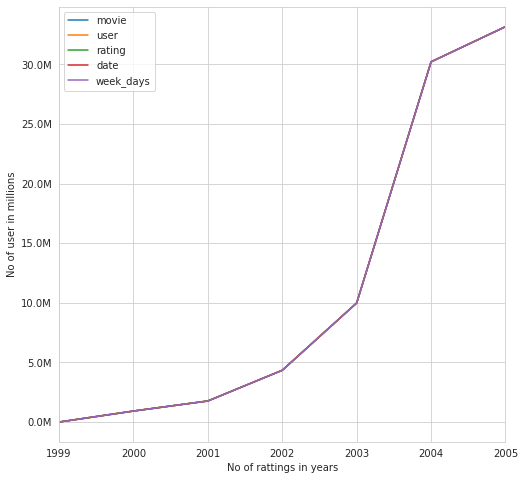

In [ ]:
ax=train_df.resample('y',on='date').count().plot(figsize=(8,8))
ax.set_ylabel("No of user in millions")
ax.set_xlabel('No of rattings in years')
ax.set_yticklabels([human(items,'m') for items in ax.get_yticks()])
plt.show()

Analysis on the rating given by the user

In [ ]:
no_of_rated_movie_per_user=train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

In [ ]:
no_of_rated_movie_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

This indicates the top 5 movies who got rated in highest in descending form.This shows that user 305344 rated 17112 movies.

In [ ]:
sum(no_of_rated_movie_per_user==False)

0

In [ ]:
len(no_of_rated_movie_per_user)

405041

In [ ]:
min(no_of_rated_movie_per_user)

1

The above three code snippets indicate that every user rated atleast one movie.How ever the one who rated less movies might also lead to cold start problem as we can't able to computr user-user similarity.

Text(0.5, 0, 'No of rating given by the user')

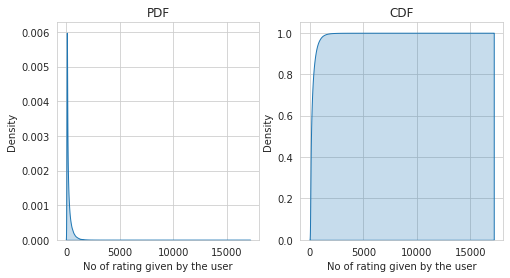

In [ ]:
fig=plt.figure(figsize=plt.figaspect(0.5))
ax1=plt.subplot(121)
plt.title("PDF")
sns.kdeplot(no_of_rated_movie_per_user,shade=True,ax=ax1,gridsize=1800)
ax1.set_xlabel("No of rating given by the user")

ax2=plt.subplot(122)
plt.title("CDF")
sns.kdeplot(no_of_rated_movie_per_user,shade=True,cumulative=True,gridsize=1800,ax=ax2)
ax2.set_xlabel("No of rating given by the user")

This indicates that 17k movies got rated.which prefers to say that item-item similarity is best for the recommendation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


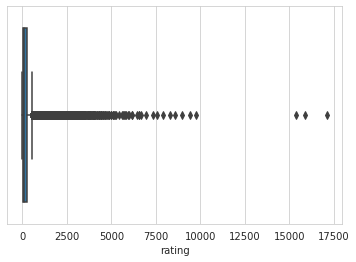

In [ ]:
sns.boxplot(no_of_rated_movie_per_user)

The above plot indicates that there are some outliers but as the given data is somewhat sparse we can't destroy the outliers untill it is changing the accuracy.

In [ ]:
no_of_rated_movie_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

In [ ]:
#calculating the IQR
Q1=34
Q3=245
IQR=Q3-Q1
LowestFense=Q1-(1.5*IQR)
HighestFense=Q3+(1.5*IQR)
print(LowestFense,HighestFense)

-282.5 561.5


However,as the lowest rating is of 0 so we ignore -282.5 and lets consider the highest fense 561.5.There are so many ratings above the 561 which also shown in boxplot but we can't ignore as 1.5 const may also get changed in domain knowledge way.

In [ ]:
quantiles=no_of_rated_movie_per_user.quantile(np.arange(0,1.01,0.01),interpolation="higher")

In [ ]:
quantiles

0.00        1
0.01        1
0.02        2
0.03        4
0.04        5
        ...  
0.96      829
0.97      934
0.98     1079
0.99     1341
1.00    17112
Name: rating, Length: 101, dtype: int64

In [ ]:
type(quantiles)

pandas.core.series.Series

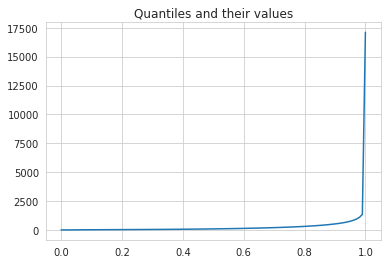

In [ ]:
plt.title("Quantiles and their values")
quantiles.plot()

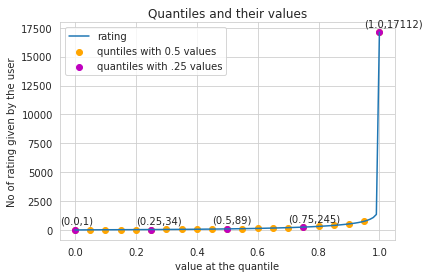

In [ ]:
plt.title("Quantiles and their values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5],y=quantiles.values[::5],color='orange',label='quntiles with 0.5 values')
plt.scatter(x=quantiles.index[::25,],y=quantiles.values[::25],color='m',label='quantiles with .25 values')
plt.ylabel("No of rating given by the user")
plt.xlabel("value at the quantile")
plt.legend(loc='best')

for x,y in zip(quantiles.index[::25],quantiles.values[::25]):
  plt.annotate("({},{})".format(x,y),xy=(x,y),xytext=(x-0.05,y+500))

This indicates that 25% of movies have less than 34 ratings,50 % of movies have less than or equal to 89 ratings,75% movie have less than or equal to 245 ratings and 100% movies have less or equalto 17112 ratings.Also the higest rating is of 17112 and the lowest rating is of 1.

In [ ]:
quantiles.values[::25]

array([    1,    34,    89,   245, 17112])

In [ ]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

Takeaways:
Almost 95% user are rated movie in a less than 800 where as 5 % user rated the movie in a high number

In [ ]:
## Last 5% user rating
print("No of movie rated by the last 5 % users is of:",sum(no_of_rated_movie_per_user>=749))

No of movie rated by the last 5 % users is of: 20305


Takeaways:
20305 movie are rated by the last 5 percent of user

DataAnalysis on the movie

In [ ]:
no_of_rating_per_movie=train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

In [ ]:
no_of_rating_per_movie

movie
5317     179684
15124    176811
1905     160062
6287     155787
14313    153899
          ...  
16410         1
14318         1
2534          1
933           1
15331         1
Name: rating, Length: 17424, dtype: int64

movie no 5317 got the higest ratings of 179684 where as the movie no 15124 got the 176811 ratings.All these ratings are provided by the users thats why no movie rating shouldn't exceeded the no of 405041.May be the higest rated movie might be titanic,avatar,avengers,RRR like that.

Text(0.5, 1.0, 'CDF')

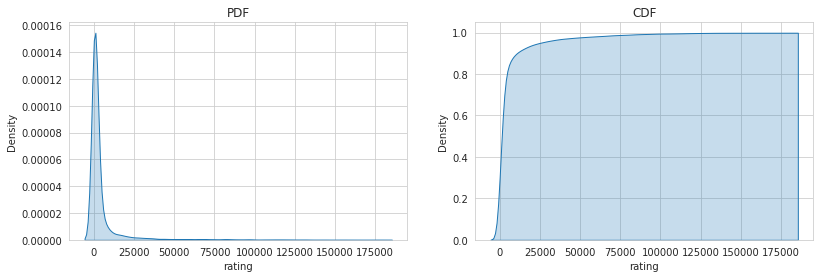

In [ ]:
fig=plt.figure(figsize=plt.figaspect(0.3))
ax1=plt.subplot(121)
#ax1.set_yticklabels([human(items,'k') for items in ax1.get_yticks()])

sns.kdeplot(no_of_rating_per_movie,shade=True,ax=ax1)
plt.title("PDF")
ax2=plt.subplot(122)
sns.kdeplot(no_of_rating_per_movie,shade=True,cumulative=True,ax=ax2)
#ax2.set_yticklabels([human(items,'k') for items in ax2.get_yticks()])

ax2.set_title("CDF")


Which indicates that every movie present got rated atleast one user of minimum of one rating.

Text(0.5, 0, 'CDF')

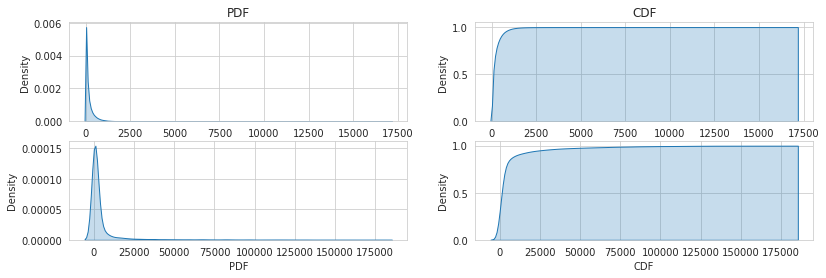

In [ ]:
##comaparing no_of_movie_rated vs no_of_rated_movie_per_user
fig=plt.figure(figsize=plt.figaspect(0.3))
ax1=plt.subplot(221)
sns.kdeplot(no_of_rated_movie_per_user,shade=True,ax=ax1)
#ax1.set_yticklabels([human(items,'m') for items in ax1.get_yticks()])
plt.title("CDF")
plt.title("PDF")

ax2=plt.subplot(222)
sns.kdeplot(no_of_rated_movie_per_user,shade=True,cumulative=True,ax=ax2)
#ax2.set_yticklabels([human(items,'m') for items in ax2.get_yticks()])
plt.title("CDF")

ax3=plt.subplot(223)
sns.kdeplot(no_of_rating_per_movie,shade=True,ax=ax3)
#ax3.set_yticklabels([human(items,'m') for items in ax3.get_yticks()])
plt.xlabel("PDF")

ax4=plt.subplot(224)
sns.kdeplot(no_of_rating_per_movie,shade=True,cumulative=True,ax=ax4)
#ax4.set_yticklabels([human(items,'m') for items in ax4.get_yticks()])
plt.xlabel("CDF")


In [ ]:
no_of_rating_per_movie.describe()

count     17424.000000
mean       4613.430039
std       13736.048971
min           1.000000
25%         147.000000
50%         435.000000
75%        2188.500000
max      179684.000000
Name: rating, dtype: float64

In [ ]:
quantiles=no_of_rating_per_movie.quantile(np.arange(0,1.01,0.01),interpolation='higher')

In [ ]:
quantiles

0.00         1
0.01         6
0.02        21
0.03        39
0.04        52
         ...  
0.96     30365
0.97     38336
0.98     54303
0.99     78879
1.00    179684
Name: rating, Length: 101, dtype: int64

In [ ]:
quantiles[::5]

0.00         1
0.05        63
0.10        87
0.15       105
0.20       124
0.25       147
0.30       178
0.35       217
0.40       271
0.45       342
0.50       435
0.55       577
0.60       784
0.65      1086
0.70      1574
0.75      2190
0.80      3296
0.85      5478
0.90     10139
0.95     24454
1.00    179684
Name: rating, dtype: int64

In [ ]:
print("The last 5% of movie having rating are:",sum(no_of_rating_per_movie>=24454))
print("The last 10% of movie having rating are:",sum(no_of_rating_per_movie>=10139))


The last 5% of movie having rating are: 872
The last 10% of movie having rating are: 1743


Which indicates that 872 movies have rating of greater than 24454 and also 1743 movies have ratings of greater than 10139.The 1743 which also includes 872.

Almost 90% of movie are having approx 0f less than or equal to 10139 rating 

Last 10 % of movie are of having rating of 8000 which indicates that some popular movie got rated by many user.

In [ ]:
train_df.columns

Index(['movie', 'user', 'rating', 'date', 'week_days'], dtype='object')

In [ ]:
##Analysis on the weekday of the traindataset
fig,ax=plt.subplots(figsize=plt.figaspect(0.3))
sns.countplot(x='week_days',data=train_df)
plt.title("No of rating on each day")
plt.xlabel("Day of the week")
plt.ylabel("Total No of rating")
plt.show()

In [ ]:
##Box plot on the weekday and rating
sns.boxplot(y='rating',x='week_days',data=train_df)
plt.show()

In [ ]:
##Average week df
avg_week_df=train_df.groupby(by='week_days')['rating'].mean()
print('Avg rating')
print('#'*50)
print(avg_week_df)

Avg rating
##################################################
week_days
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64


In [ ]:
train_df=train_df.drop(['week_days'],axis=1)

In [ ]:
train_df.columns

Index(['movie', 'user', 'rating', 'date'], dtype='object')

**Creating sparse matrix from dataframe**



In [ ]:
start_time=datetime.now()
if os.path.isfile('/content/drive/MyDrive/netflix files/train_sparse_matrix.npz'):
  print("The file is in pwd so extracting it...... ")
  train_sparse_matrix=sparse.load_npz('/content/drive/MyDrive/netflix files/train_sparse_matrix.npz')
  print('Done...')

else:
  print("The sparse matrix is now creating...")
  train_sparse_matrix=sparse.csr_matrix((train_df.rating,(train_df.user,train_df.movie)))
  print('saving it into the disk for futher usage')
  sparse.save_npz('train_sparse_matrix.npz',train_sparse_matrix)
  print('Done....')
print("The time taken to run this module is of",datetime.now()-start_time)


The file is in pwd so extracting it...... 
Done...
The time taken to run this module is of 0:00:05.334131


In [ ]:
##creating the sparse matrix for the test_data.csv
if os.path.isfile('/content/drive/MyDrive/netflix files/test_sparse_matrix.npz'):
  print('The file is found in your pwd extracting it....')
  test_sparse_matrix=sparse.load_npz('/content/drive/MyDrive/netflix files/test_sparse_matrix.npz')
  print('Done....')
else:
  print('The file is not found in your hard disk..... ')
  print('Creating the new sparse matrix for the test data')
  test_sparse_matrix=sparse.csr_matrix((test_df.rating,(test_df.user,test_df.movie)))
  print('Saving it into the disk for future purposes')
  sparse.save_npz('test_sparse_matrix',test_sparse_matrix)
  print('Done.....')

The file is found in your pwd extracting it....
Done....


In [ ]:
print(train_sparse_matrix.shape)
print(test_sparse_matrix.shape)

(2649430, 17771)
(2649430, 17771)


The sparse matrix stores in its form to reduce the memory space.However it never corrupt the shapes of the orginal matrix(train_matrix and test_matrix) in this case.

The sparsity of the train_sparse_matrix and test_sparse_matrix

In [ ]:
r1,c1=train_sparse_matrix.shape
r2,c2=test_sparse_matrix.shape
not_sparse_train=train_sparse_matrix.count_nonzero()
not_sparse_test=test_sparse_matrix.count_nonzero()
print('The sparsity over the train_df is of ',(1-((not_sparse_train)/(r1*c1)))*100)
print('The sparsity over the test_df is of ',(1-(not_sparse_test)/(r2*c2))*100)

The sparsity over the train_df is of  99.8292709259195
The sparsity over the test_df is of  99.95731772988694


Takeaway:The sparsity of the train_df and test_df is almost 99.9percent and 99.9 percent But if we created the orginal matrix the memomry would have been exhausted for the entire matrix creation 

<h3>Finding the global average of all the movie rating,Average rating per user,Average rating per movie</h3>

In [ ]:
train_average=dict()
train_global_average=train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_average['global']=train_global_average
print(train_average)

{'global': 3.582890686321557}


**Finding average rating per user**

In [ ]:

# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_rating(sparse_matrix, of_user):
    
    # average rating of user/axes
    ax = 1 if of_user else 0 
    # 1 - User axes showing that the ag rating of user on movies,0 - Movie axes indicates that the avg movie raiting on by all users.

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_rating = sparse_matrix.sum(axis=ax).A1
    is_rated = sparse_matrix!=0
    no_of_rating = is_rated.sum(axis=ax).A1

    u,m = sparse_matrix.shape
    average_rating = { i : sum_of_rating[i]/no_of_rating[i]
                                 for i in range(u if of_user else m) 
                                    if no_of_rating[i] !=0}

    return average_rating


In [ ]:
starttime=datetime.now()
train_average['user'] = get_average_rating(train_sparse_matrix, of_user=True)
print('\nAverage rating of user 10 :',train_average['user'][10])
print(datetime.now()-starttime)



Average rating of user 10 : 3.3781094527363185
0:00:02.034615


In [ ]:
len(train_average['user'])

405041

In [ ]:
start_time=datetime.now()
train_average['movie']=get_average_rating(train_sparse_matrix,of_user=False)
print('the average movie rating of 15 th movie is:',train_average['movie'][15])
print(datetime.now()-start_time)

the average movie rating of 15 th movie is: 3.3038461538461537
0:00:00.826383


PDf and cdf of avg rating

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

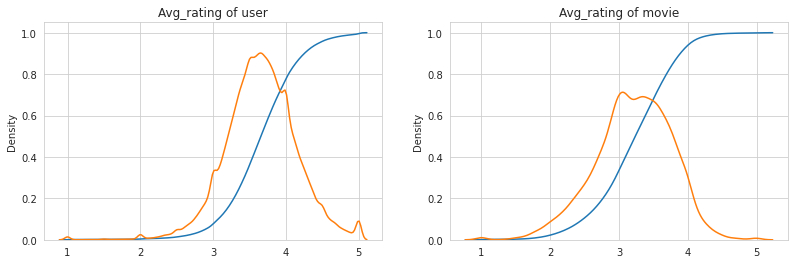

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=plt.figaspect(0.3))
plt.title('Avg rating of the user and movie',fontsize=15)
ax1.set_title('Avg_rating of user')
ax2.set_title('Avg_rating of movie')
user_avgs=[rati for rati in train_average['user'].values()]
sns.distplot(user_avgs,hist=False,kde_kws=dict(cumulative=True),label='CDF',ax=ax1)
sns.distplot(user_avgs,hist=False,label='PDF',ax=ax1)
movie_avgs=[rati for rati in train_average['movie'].values()]
sns.distplot(movie_avgs,hist=False,kde_kws=dict(cumulative=True),label='CDF',ax=ax2)
sns.distplot(movie_avgs,hist=False,ax=ax2)


Take aways:
The plot looks like bernolli distribution but tail looks some what long (pdf)

Cold start problem

In [ ]:
df=pd.read_csv('/content/data.csv',sep=',',names=['movie','user','rating','date'])

In [ ]:
total_users = len(np.unique(df.user))
users_train = len(train_average['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


 We might have to handle __new users__ ( ___75148___ ) who didn't appear in train data.

__Cold start problem with movies__

In [ ]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_average['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


<h3> Computing Similarity matrices</h3>
Computing User-User Similarity matrix

Calculating User User Similarity_Matrix is not very easy(unless you have huge Computing Power and lots of time) because of number of userbeing lare.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
  
  no_of_users, _ = sparse_matrix.shape
  # get the indices of  non zero rows(users) from our sparse matrix
  row_ind, col_ind = sparse_matrix.nonzero()
  row_ind = sorted(set(row_ind)) # we don't have to
  time_taken = list() #  time taken for finding similar users for an user..
    
    # we create rows, cols, and data lists.., which can be used to create sparse matrices
  rows, cols, data = list(), list(), list()
  if verbose: print("Computing top",top,"similarities for each user..")
    
  start = datetime.now()
  temp = 0
    
  for row in row_ind[:top] if compute_for_few else row_ind:
    temp = temp+1
    prev = datetime.now()
        
    # get the similarity row for this user with all other users
    sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
    # We will get only the top ''top'' most similar users and ignore rest of them..
    top_sim_ind = sim.argsort()[-top:]
    top_sim_val = sim[top_sim_ind]
        
    # add them to our rows, cols and data
    rows.extend([row]*top)
    cols.extend(top_sim_ind)
    data.extend(top_sim_val)
    time_taken.append(datetime.now().timestamp() - prev.timestamp())
    if verbose:

      if temp%verb_for_n_rows == 0:

        print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
  # lets create sparse matrix out of these and return it
  if verbose: print('Creating Sparse matrix from the computed similarities')
  #return rows, cols, data
    
  if draw_time_taken:

    plt.plot(time_taken, label = 'time taken for each user')
    plt.plot(np.cumsum(time_taken), label='Total time')
    plt.legend(loc='best')
    plt.xlabel('User')
    plt.ylabel('Time (seconds)')
    plt.show()
        
  return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken      

Computing top 50 similarities for each user..
computing done for 20 users [  time elapsed : 0:02:01.725834  ]
computing done for 40 users [  time elapsed : 0:03:58.537281  ]
Creating Sparse matrix from the computed similarities


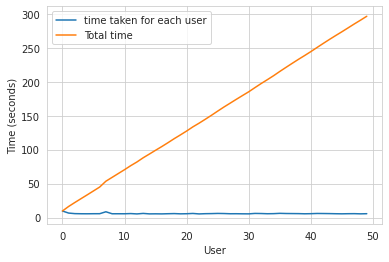

______________________________________________________________________________________________________________________________________________________
total_time taken for computing 100 user is of:  0:05:06.589066


In [ ]:
start=datetime.now()
u_u_similarity, _ =compute_user_user_similarity(train_sparse_matrix,compute_for_few=True,top=50,verbose=True)
print("_"*150)
print('total_time taken for computing 100 user is of: ',datetime.now()-start)

So for computing for the 100 user of the top 50 similar users take almost5 mins so if we try to compute for 405 k users of 50 similar users then it is going to take 20250 mins which is equal to 337 hours which in turn equal 14+days.So its not an easy task so user user similarity is not preferred.However if we have high resources,on computing parallely on 4 core we acqurire the result in 3+days.

Solution:Whenever we recommending a particular user then we compute for that particular user only so that it can be processed in almost 1 to 2 mins.

<h3> Computing movie movie similarity</h3>

In [ ]:
start=datetime.now()
if not os.path.isfile('m_m_sim.npz'):
  print('There is no file present in your pwd so,creating the file of m_m_sim.npz')
  m_m_sim=cosine_similarity(X=train_sparse_matrix.T,dense_output=False)
  print('saving it into the disk for future purposes')
  sparse.save_npz('m_m_sim',m_m_sim)
  print('The file got saved...')
else:
  print('The file is present in your pwd....')
  print('Loading the file....')
  m_m_sim=sparse.load_npz('m_m_sim.npz')
  print('Done')
print('It is a ',m_m_sim.shape,'dimension matrix')
print('The time taken is :',datetime.now()-start)


The file is present in your pwd....
Loading the file....
Done
It is a  (17771, 17771) dimension matrix
The time taken is : 0:00:36.260117


In [ ]:
movie_ids=np.unique(m_m_sim.nonzero()[0])

In [ ]:
start=datetime.now()
similar_movie=dict()
for movie in movie_ids:
  sim_movie=m_m_sim[movie].toarray().ravel().argsort()[::-1][1:]
  similar_movie[movie]=sim_movie[:100]
print(datetime.now()-start)
similar_movie[15]


0:00:31.287687


array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973,  1720,  5370, 16309,  9376,  6116,  4706,  2818,
         778, 15331,  1416, 12979, 17139, 17710,  5452,  2534,   164,
       15188,  8323,  2450, 16331,  9566, 15301, 13213, 14308, 15984,
       10597,  6426,  5500,  7068,  7328,  5720,  9802,   376, 13013,
        8003, 10199,  3338, 15390,  9688, 16455, 11730,  4513,   598,
       12762,  2187,   509,  5865,  9166, 17115, 16334,  1942,  7282,
       17584,  4376,  8988,  8873,  5921,  2716, 14679, 11947, 11981,
        4649,   565, 12954, 10788, 10220, 10963,  9427,  1690,  5107,
        7859,  5969,  1510,  2429,   847,  7845,  6410, 13931,  9840,
        3706])

:<h2>Finding the similarity movie using movie movie similarity</h2>

To check lets use the movie title.csv which is got extracted in netflix prize dataset

In [ ]:
movie_titles=pd.read_csv('/content/movie_titles.csv',names=['movie_id', 'year_of_release', 'title'],encoding="ISO-8859-1",index_col='movie_id',verbose=True,header=None)

Tokenization took: 3.89 ms
Type conversion took: 9.52 ms
Parser memory cleanup took: 0.01 ms


In [ ]:
movie_titles.head()

,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [ ]:
dataframe=movie_titles[movie_titles['title']=='Vampire Journals']

In [ ]:
dataframe

,year_of_release,title
movie_id,,
67,1997.0,Vampire Journals


In [ ]:
similar_movie[67]

array([  323,  4044,  1688, 13962, 12053, 16279,  4667,  1900, 13873,
       15867,  6743,  7573, 16315,  2004, 14338, 14292, 13905,   415,
       13812,  5373,  3496, 15237,  7520, 15961, 12749,  9911,   938,
       12898,  2948, 10649, 11609,  4111, 11627, 14541, 12790,  4173,
        2633,  9674, 13262, 11345,  6306,  9045, 14765, 10960,  2670,
       17243,  6022,  8565,  6818,  9304,   399,  5131, 10370, 13616,
         408, 14520,  6208,  2233,  9151,  5197,  3043,  4021,  8180,
        1570, 13637, 10653, 12990, 16290, 13333,  1624, 15438,  3828,
        6130,  1723, 15414,  5568,  8686, 12814, 13445,  1768,   887,
       16804, 17648,  9157, 12659,  6411,  9308, 13917,  8952,  8936,
        2231,  2667, 15108,  8439,  4469, 11536,  9338, 15728, 14931,
         726])

In [ ]:
movie_id=67
print('The movie of movie_id 67------->',movie_titles.loc[movie_id].values[1])
print('The number of user rated this movie is of:{}'.format(train_sparse_matrix[:,67].getnnz()))
print('The number of similar movie for this movie is of:{}'.format(m_m_sim[:,67].getnnz()))

The movie of movie_id 67-------> Vampire Journals
The number of user rated this movie is of:270
The number of similar movie for this movie is of:17284


In [ ]:
similarities=m_m_sim[movie_id].toarray().ravel()
sim_ind=similarities.argsort()[::-1][1:]


In [ ]:
sim_ind.shape

(17770,)

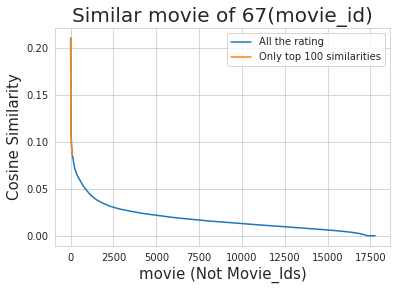

In [ ]:
plt.plot(similarities[sim_ind],label='All the rating')
plt.plot(similarities[sim_ind[:100]],label='Only top 100 similarities')
plt.title("Similar movie of {}(movie_id)".format(movie_id), fontsize=20)
plt.xlabel("movie (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

In [ ]:
movie_titles.loc[sim_ind[:15]]

,year_of_release,title
movie_id,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
13962,2001.0,Dracula: The Dark Prince
12053,1993.0,Dracula Rising
16279,2002.0,Vampires: Los Muertos
4667,1996.0,Vampirella
1900,1997.0,Club Vampire
13873,2001.0,The Breed


Take aways:
These are the movie which are similar to the movie of 67(vampire journals)..

Future doubt reference for the csr matrix

In [ ]:
a=csr_matrix([[1,2,3,4,5,5],[0,0,0,0,0,0],[5,6,0,8,9,0]])

In [ ]:
sparse.find(a)

(array([0, 2, 0, 2, 0, 0, 2, 0, 2, 0], dtype=int32),
 array([0, 0, 1, 1, 2, 3, 3, 4, 4, 5], dtype=int32),
 array([1, 5, 2, 6, 3, 4, 8, 5, 9, 5]))

In [ ]:
a.toarray()

array([[1, 2, 3, 4, 5, 5],
       [0, 0, 0, 0, 0, 0],
       [5, 6, 0, 8, 9, 0]])

In [ ]:
row_ind,col_ind,rating=sparse.find(a)

In [ ]:
user=np.unique(row_ind)

In [ ]:
user

array([0, 2], dtype=int32)

In [ ]:
movie=np.unique(col_ind)

In [ ]:
m=np.unique(col_ind)

In [ ]:
 mask=np.logical_and(np.isin(row_ind,user),np.isin(col_ind,movie))
 print(user)
 print(row_ind)
 print(movie)
 print(col_ind)
 print(mask)
 print(np.isin(row_ind,user))
 print(np.isin(col_ind,movie))

[0 2]
[0 2 0 2 0 0 2 0 2 0]
[0 1 2 3 4 5]
[0 0 1 1 2 3 3 4 4 5]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]


<h3>Machine Learning Models</h3>

Time for regression based recommendation system
(__content Based Recommendation System__)

In [ ]:
def get_sample_sparse_matrix(sparse_matrix,no_of_user,no_of_movie,path,verbose=True):
  row_ind,col_ind,rating=sparse.find(sparse_matrix)
  user=np.unique(row_ind)
  movie=np.unique(col_ind)
  print('user',user)
  print('movie',movie)

  print('The orginal matrix is of size({},{})'.format(len(user),len(movie)))
  print('The orginal matrix rattings is of {}'.format(len(rating)))
  ##To get the same random choices we use seed
  np.random.seed(15)
  sample_user=np.random.choice(user,no_of_user,replace=False)
  sample_movie=np.random.choice(movie,no_of_movie,replace=False)
  
  #print('sample_movie',sample_movie)
  #print('sample_user',sample_user)

  ##get the boolean mask or these sampled items in orginal rows/cols
  mask=np.logical_and(np.isin(row_ind,sample_user),np.isin(col_ind,sample_movie))
  print(len(mask))

  sample_sparse_matrix=sparse.csr_matrix((rating[mask],(row_ind[mask],col_ind[mask])),shape=(max(sample_user)+1,max(sample_movie)+1))
  if verbose:
        print("Sampled Matrix : (user, movie) -- ({} {})".format(len(sample_user), len(sample_movie)))
        print("Sampled Matrix : rating --", format(rating[mask].shape[0]))

  #print('Saving it into disk for furthur usage..')
  # save it into disk
  sparse.save_npz(path, sample_sparse_matrix)

  if verbose:

    print('Done..\n')
    
  return sample_sparse_matrix




<h3>Sampling data</h3>
why:
As the computation is not supported so we are taking the random samples of the train and test data.

In [ ]:
start=datetime.now()
if os.path.isfile('/content/drive/MyDrive/netflix files/sample_train_sparse_matrix.npz'):
  print('The file is present in yout pwd....')
  print('Loading the file.....')
  sampled_train_sparse_matrix=sparse.load_npz('/content/drive/MyDrive/netflix files/sample_train_sparse_matrix.npz')
else:
  print('The file is not present in your pwd so creating the new one...')
  sampled_train_sparse_matrix=get_sample_sparse_matrix(train_sparse_matrix,no_of_user=10000,no_of_movie=1000,verbose=True,path='/content/drive/MyDrive/netflix files/sample_train_sparse_matrix.npz')
  sparse.save_npz('sampled_train_sparse_matrix',sampled_train_sparse_matrix)
print(datetime.now()-start)

The file is present in yout pwd....
Loading the file.....
0:00:00.054324


In [ ]:
##Creating the sampling data to the test data
start=datetime.now()
path='/content/drive/MyDrive/netflix files/sample_test_sparse_matrix.npz'
if os.path.isfile(path):
  print('The file is present in your pwd....')
  print('Loading the file')
  sampled_test_sparse_matrix=sparse.load_npz(path)
  print('done')
else:
  print('The file is not present in your pwd so creating the new one...')
  sampled_test_sparse_matrix=get_sample_sparse_matrix(test_sparse_matrix,no_of_user=5000,no_of_movie=500,verbose=True,path=path)
  print('Done.....')
print(datetime.now()-start)

The file is present in your pwd....
Loading the file
done
0:00:00.476008


In [ ]:
sample_train_averages=dict()

Finding Global avg of all sample_train_rating

In [ ]:
global_avg=sampled_train_sparse_matrix.sum()/sampled_train_sparse_matrix.count_nonzero()
sample_train_averages['global_avg_rating']=global_avg

In [ ]:
sample_train_averages['global_avg_rating']

3.581679377504138

In [ ]:
sample_train_averages['user'] =get_average_rating(sampled_train_sparse_matrix, of_user=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.9655172413793105


In [ ]:
sample_train_averages['movie'] =get_average_rating(sampled_train_sparse_matrix, of_user=False)
print('\nAverage rating of user 1515220 :',sample_train_averages['movie'][15153])


Average rating of user 1515220 : 2.6458333333333335


Featurizing Data

In [ ]:
print('No of rating in our sample train sparse matrix  {}'.format(sampled_train_sparse_matrix.count_nonzero()))
print('No of rating in our sampled test sparse matrix  {}'.format(sampled_test_sparse_matrix.count_nonzero()))


No of rating in our sample train sparse matrix  129286
No of rating in our sampled test sparse matrix  7333


Featurizing data for regressio problem

Train data featurizing

In [ ]:
sample_train_user,sample_train_movie,sample_train_rating=sparse.find(sampled_train_sparse_matrix)

In [ ]:
################################################
##It took me 7 hours to run this tuples.......##
################################################
global_start=datetime.now()
if os.path.isfile('/content/drive/MyDrive/netflix files/reg_train.csv'):
  print('The file is already present in the pwd no need to create a new one.....')
else:
  count=0
  with open('/content/drive/MyDrive/netflix files/reg_train.csv',mode='w') as reg_data_file:
    print('Preparing {} tuples for the dataset........'.format(len(sample_train_rating)))
    start=datetime.now()
    for (user,movie,rating) in zip(sample_train_user,sample_train_movie,sample_train_rating):
      sim_user=cosine_similarity(sampled_train_sparse_matrix[user],sampled_train_sparse_matrix).ravel()
      top_sim_user=sim_user.argsort()[::-1][1:]
      ##finding out who are the top user who rated the movie also top 5 sim user
      top_rating=sampled_train_sparse_matrix[top_sim_user,movie].toarray().ravel()
      top_sim_user_rating=list(top_rating[top_rating!=0][:5])
      top_sim_user_rating.extend([sample_train_averages['movie'][movie]]*(5-len(top_rating)))

      ##---------------------------------movie file creation----------------------------------##
      sim_movie=cosine_similarity(sampled_train_sparse_matrix[:,movie].T,sampled_train_sparse_matrix.T).ravel()
      top_sim_movie=sim_movie.argsort()[::-1][1:]
      # get the rating of most similar movie rated by this user..
      top_rating=sampled_train_sparse_matrix[user,top_sim_movie].toarray().ravel()
      top_sim_movie_rating=list(top_rating[top_rating!=0][:5])
      top_sim_movie_rating.extend([sample_train_averages['user'][user]]*(5-len(top_rating)))

      ##-------------------------------------creating the reg_data_file-------------------------##

      row=list()
      row.append(user)
      row.append(movie)
      row.append(sample_train_averages['global_avg_rating'])
      #Adding the similar usrs
      row.extend(top_sim_user_rating)
      #Adding the similar movie
      row.extend(top_sim_movie_rating)
      #Avg user rating
      row.append(sample_train_averages['user'][user])
      #Avg movie rating
      row.append(sample_train_averages['movie'][movie])

      row.append(rating)
      count+=1

      # add rows to the file opened..
      reg_data_file.write(','.join(map(str, row)))
      reg_data_file.write('\n')        
      if count%10000==0:
        print('Done for {}---rows{}'.format(count,datetime.now()-start))
print(datetime.now()-global_start)


  










The file is already present in the pwd no need to create a new one.....
0:00:00.001814


In [ ]:
reg_train = pd.read_csv('/content/drive/MyDrive/netflix files/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


In [ ]:
reg_train.tail()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
129281,2585154,17723,3.581679,3.0,3.0,4.0,4.0,4.0,3.0,5.0,4.0,5.0,4.0,4.204819,3.811765,5
129282,2604824,17723,3.581679,5.0,3.0,4.0,2.0,3.0,3.0,4.0,5.0,5.0,3.0,4.057471,3.811765,5
129283,2622281,17723,3.581679,4.0,3.0,3.0,5.0,3.0,3.0,3.0,3.0,3.0,2.0,3.166667,3.811765,3
129284,2627366,17723,3.581679,4.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,3.594203,3.811765,4
129285,2629799,17723,3.581679,3.0,4.0,4.0,5.0,5.0,4.0,3.0,4.0,4.0,3.0,3.631579,3.811765,4


-----------------------

- __GAvg__ : Average rating of all the rating 


- __Similar user rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar user who rated that movie.. )
    


- __Similar movie rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movie rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

**Featurizing the test data**

In [ ]:
# get user, movie and rating from the Sampled Test 
sample_test_user, sample_test_movie, sample_test_rating = sparse.find(sampled_test_sparse_matrix)

In [ ]:
global_start = datetime.now()

if os.path.isfile('/content/drive/MyDrive/netflix files/reg_test.csv'):
    print("It is already created...")
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_rating)))
    with open('/content/drive/MyDrive/netflix files/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_user, sample_test_movie, sample_test_rating):
            st = datetime.now()

        #--------------------- rating of "movie" by similar user of "user" ---------------------#
            #print(user, movie)
            try:
                user_sim = cosine_similarity(sampled_train_sparse_matrix[user], sampled_train_sparse_matrix).ravel()
                top_sim_user = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar user.
                # get the rating of most similar user for this movie
                top_rating = sampled_train_sparse_matrix[top_sim_user, movie].toarray().ravel()
                top_sim_user_rating = list(top_rating[top_rating != 0][:5])
                top_sim_user_rating.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_user_rating)))

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no rating for given user for top similar movie...
                ########## Cold STart Problem ##########
                top_sim_user_rating.extend([sample_train_averages['global_avg_rating']]*(5 - len(top_sim_user_rating)))
            except:
                print(user, movie)
                raise



            #--------------------- rating by "user"  to similar movie of "movie" ---------------------
            try:
                movie_sim = cosine_similarity(sampled_train_sparse_matrix[:,movie].T, sampled_train_sparse_matrix.T).ravel()
                top_sim_movie = movie_sim.argsort()[::-1][1:] 
                top_rating = sampled_train_sparse_matrix[user, top_sim_movie].toarray().ravel()
                top_sim_movie_rating = list(top_rating[top_rating != 0][:5])
                top_sim_movie_rating.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movie_rating))) 
            except (IndexError, KeyError):
                
                top_sim_movie_rating.extend([sample_train_averages['global_avg_rating']]*(5-len(top_sim_movie_rating)))
  
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global_avg_rating']) # first feature
            #print(row)
            # next 5 features are similar_user "movie" rating
            row.extend(top_sim_user_rating)
            #print(row)
            # next 5 features are "user" rating for similar_movie
            row.extend(top_sim_movie_rating)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global_avg_rating'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global_avg_rating'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - global_start)  

It is already created...


In [ ]:
reg_test = pd.read_csv('/content/drive/MyDrive/netflix files/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test.head(5)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1


-----------------------

- __GAvg__ : Average rating of all the rating 


- __Similar user rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular user who rated that movie.. )
    


- __Similar movie rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movie rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

**Transforming data for surprise models**

**Using the surprise models**

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 5.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633988 sha256=399981def463c1cd2a849bb3a89e872d1c03d78d8be6c400364c4a7b5a4c9670
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import Reader,Dataset

In [ ]:
reader=Reader(rating_scale=(1,5))
train_data=Dataset.load_from_df(reg_train[['user','movie','rating']],reader)

train_set=train_data.build_full_trainset()

Data transformation for surprise library is not understood as it changes it to the form required for its faster and easy computation.For documentation look at surprise library docs.

In [ ]:
##Transforming the data for the test
test_set=list(zip(reg_test.user.values,reg_test.movie.values,reg_test.rating.values))
test_set[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

In [ ]:
len(test_set)

76

In [ ]:
type(train_set)

surprise.trainset.Trainset

In [ ]:
type(train_data)

surprise.dataset.DatasetAutoFolds

Global dictionary to store all the rmse and mape values (dictionary of dictionary)

In [ ]:
model_evaluation_train=dict()
model_evaluation_test=dict()

In [ ]:
model_evaluation_train,model_evaluation_test

({}, {})

Utility functions for running regression problems

In [ ]:
def get_error_metrics(y_true,y_pred):
   rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
   mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
   return rmse, mape
######################################################
def run_xgboost(algo,x_train,y_train,x_test,y_test,verbose=True):
  train_results=dict()
  test_results=dict()

  start=datetime.now()
  print('Training the model')
  algo.fit(x_train,y_train,eval_metric='rmse')
  print('Done...')
  print('Timetaken{}...'.format(datetime.now()-start))

  # from the trained model, get the predictions....
  print('Evaluating the model with TRAIN data...')
  start =datetime.now()
  y_train_pred = algo.predict(x_train)
  # get the rmse and mape of train data...
  rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)


  ##storing in the dictionary
  train_results={
      'rmse':rmse_train,
      'mape':mape_train,
      'predictions':y_train_pred
  }

  ##Predictig for the test data
  print('Evaluating the test data')
  start=datetime.now()
  y_test_pred=algo.predict(x_test)
  rmse_test,mape_test=get_error_metrics(y_test.values,y_test_pred)
  print('Time taken to the test dataset{}'.format(datetime.now()-start))
  test_results={
      'rmse':rmse_test,
      'mape':mape_test,
      'predictions':y_test_pred
  }
   
  if verbose:

    print('\nTEST DATA')
    print('-'*30)
    print('RMSE : ', rmse_test)
    print('MAPE : ', mape_test)
  

  return train_results,test_results

##Utility functions for surprise models

In [ ]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

# get (actual_list,predicted_list) rating given list 
# of predictions (prediction is a class in Surprise).    
def get_rating(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

# get ''rmse'' and ''mape'' , given list of prediction objecs 
def get_errors(predictions, print_them=False):

    actual, pred = get_rating(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

# It will return predicted rating, rmse and mape of both train and test data   
def run_surprise(algo, trainset, testset, verbose=True): 

        #return train_dict, test_dict
    
        #It returns two dictionaries, one for train and the other is for test
        #Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted rating''.

    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    train_preds = algo.test(trainset.build_testset())
    train_actual_rating, train_pred_rating = get_rating(train_preds)


    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
      print('adding train results in the dictionary..')
      train['rmse'] = train_rmse
      train['mape'] = train_mape
      train['predictions'] = train_pred_rating
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    test_preds = algo.test(testset)
    test_actual_rating, test_pred_rating = get_rating(test_preds)
    # get error metrics from the predicted and actual rating
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_rating
    print('test_predictions',len(test['predictions']))
    print('train_predictions',len(train['predictions']))
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    return train, test

In [ ]:
import xgboost as xgb

In [ ]:
#!pip uninstall xgboost

In [ ]:
pip install xgboost

__Xgboost regressor__

Training the model
[10:12:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done...
Timetaken0:00:06.690781...
Evaluating the model with TRAIN data...
Evaluating the test data
Time taken to the test dataset0:00:00.003103

TEST DATA
------------------------------
RMSE :  0.9941416273339712
MAPE :  36.53556629231102


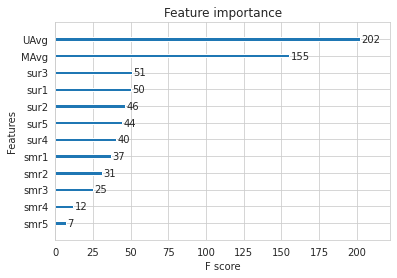

In [ ]:
x_train=reg_train.drop(['user','movie','rating'],axis=1)
y_train=reg_train['rating']

x_test=reg_test.drop(['user','movie','rating'],axis=1)
y_test=reg_test['rating']

first_xgb=xgb.XGBRegressor(n_jobs=13,n_estimators=100,random_state=15)
train_results,test_results=run_xgboost(first_xgb,x_train,y_train,x_test,y_test)

##storing it to the global dictionary
model_evaluation_train['first_algo']=train_results
model_evaluation_test['first_algo']=test_results

xgb.plot_importance(first_xgb)
plt.show()


__surprise Baseline model__

In [ ]:
from surprise import BaselineOnly

__Predicted_rating : ( baseline prediction ) __

    -  http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly 
 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all rating in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 

__Optimization function ( Least Squares Problem ) __

    - http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

In [ ]:
bsl_options={'method':'sgd',
             'learning_rate':0.001}
bsl_algo=BaselineOnly(bsl_options=bsl_options)

bsl_train_results,bsl_test_results=run_surprise(bsl_algo,train_set,test_set,verbose=True)

model_evaluation_train['bsl_algo']=bsl_train_results
model_evaluation_test['bsl_algo']=bsl_test_results

#print(len(bsl_train_results['predictions']))



Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:01.124892 

Evaluating the model with train data..
time taken : 0:00:01.186017
---------------
Train Data
---------------
RMSE : 0.9347153928678286

MAPE : 29.389572652358183

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.000925
---------------
Test Data
---------------
RMSE : 1.0127958755414286

MAPE : 37.70008017719995

storing the test results in test dictionary...
test_predictions 76
train_predictions 129286

---------------------------------------------
Total time taken to run this algorithm : 0:00:02.313630


__Xgboost +13 initial handcrafted featrues__+__Surprise Baseline model__

In [ ]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = model_evaluation_train['bsl_algo']['predictions']
reg_train.head() 
#len(reg_train)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5,3.323708
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5,3.378411
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5,3.691637


In [ ]:
##adding the new column to the test data
reg_test['bslpr']=model_evaluation_test['bsl_algo']['predictions']
reg_test.head()
#len(reg_test)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3,3.581679
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1,3.581679


In [ ]:
reg_train.columns

Index(['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5', 'smr1',
       'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating', 'bslpr'],
      dtype='object')

Training the model
[10:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done...
Timetaken0:00:07.785673...
Evaluating the model with TRAIN data...
Evaluating the test data
Time taken to the test dataset0:00:00.002078

TEST DATA
------------------------------
RMSE :  0.9936561473679958
MAPE :  36.49951172502418


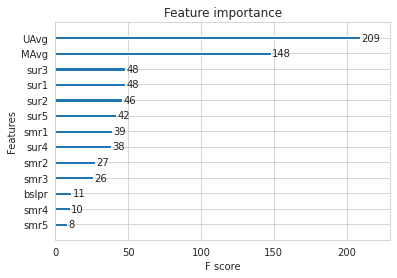

In [ ]:
#prepare the train and test data
x_train=reg_train.drop(['user','movie','rating'],axis=1)
y_train=reg_train['rating']

#print(x_train.columns)

x_test=reg_test.drop(['user','movie','rating'],axis=1)
y_train=reg_train['rating']

#initialize our first xgboost model
xgb_bsl=xgb.XGBRegressor(njobs=13,n_estimators=100,random_state=15)
train_results,test_results=run_xgboost(xgb_bsl,x_train,y_train,x_test,y_test)

model_evaluation_train['xgb_bsl']=train_results
model_evaluation_test['xgb_bsl']=test_results

#print(model_evaluation_train['xgb_bsl'])

xgb.plot_importance(xgb_bsl)
plt.show()

__Surprise KNN baseline with user-user similarity__

In [ ]:
from surprise import KNNBaseline

In [ ]:
sim_options={'user_based':True,
             'name':'pearson_baseline',
             'shrinkage':100,
             'min_support':2
}
bsl_options={'method':'sgd'}

knn_bsl_u=KNNBaseline(k=50,sim_options=sim_options,bsl_options=bsl_options)
knn_bsl_u_train_results,knn_bsl_u_test_results=run_surprise(knn_bsl_u,train_set,test_set,verbose=True)

model_evaluation_train['knn_bsl_u']=knn_bsl_u_train_results
model_evaluation_test['knn_bsl_u']=knn_bsl_u_test_results
                                                            
            

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:35.661598 

Evaluating the model with train data..
time taken : 0:01:50.075844
---------------
Train Data
---------------
RMSE : 0.3535546871957972

MAPE : 9.649106273315809

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.001001
---------------
Test Data
---------------
RMSE : 1.0127958755414286

MAPE : 37.70008017719995

storing the test results in test dictionary...
test_predictions 76
train_predictions 129286

---------------------------------------------
Total time taken to run this algorithm : 0:02:25.741100


__Take away:
As the traindata and test data RMSE are some what having huge difference there might be chances of overfiting og the model..__

__surprise KNN baseline with movie movie similarity__

In [ ]:
sim_options={'user_based':False,
             'name':'pearson_baseline',
             'shrinkage':100,
             'min_support':2}
bsl_options={'model':'sgd'}

knn_bsl_m=KNNBaseline(k=40,sim_options=sim_options,bsl_options=bsl_options)
knn_bsl_m_train_results,knn_bsl_m_test_results=run_surprise(knn_bsl_m,train_set,test_set,verbose=True)

model_evaluation_train['knn_bsl_m']=knn_bsl_m_train_results
model_evaluation_test['knn_bsl_m']=knn_bsl_m_test_results

Training the model...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:00.709626 

Evaluating the model with train data..
time taken : 0:00:08.475679
---------------
Train Data
---------------
RMSE : 0.3576376914112193

MAPE : 9.435891931250264

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.001613
---------------
Test Data
---------------
RMSE : 1.0127958755414286

MAPE : 37.70008017719995

storing the test results in test dictionary...
test_predictions 76
train_predictions 129286

---------------------------------------------
Total time taken to run this algorithm : 0:00:09.189744


__Take away:
Here also same that RMSE of train and test is of having some considerable diff which might gone to overfitting..__

__XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor__

First we will run XGBoost with predictions from both KNN's ( that uses User_User and Item_Item similarities along with our previous features.


In [ ]:
##Adding the prediction to the regtrain
reg_train['knn_bsl_u']=model_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m']=model_evaluation_train['knn_bsl_m']['predictions']

In [ ]:
#Adding the prediction to the reg_test
reg_test['knn_bsl_u']=model_evaluation_test['knn_bsl_m']['predictions']
reg_test['knn_bsl_m']=model_evaluation_test['knn_bsl_m']['predictions']

In [ ]:
reg_train.columns

Index(['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5', 'smr1',
       'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating', 'bslpr',
       'knn_bsl_u', 'knn_bsl_m'],
      dtype='object')

In [ ]:
reg_test.columns

Index(['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5', 'smr1',
       'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating', 'bslpr',
       'knn_bsl_u', 'knn_bsl_m'],
      dtype='object')

Training the model
[10:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done...
Timetaken0:00:08.560087...
Evaluating the model with TRAIN data...
Evaluating the test data
Time taken to the test dataset0:00:00.003543

TEST DATA
------------------------------
RMSE :  0.992718665374202
MAPE :  36.4286701616488


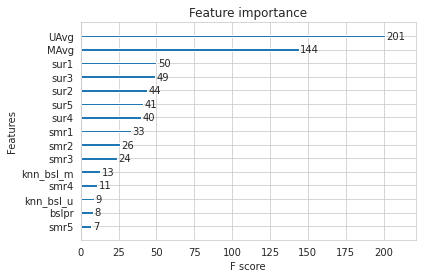

In [ ]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test.drop(['user','movie','rating'], axis=1)
y_test = reg_test['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
model_evaluation_train['xgb_knn_bsl'] = train_results
model_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

<h3> Matrix Factorization Techniques </h3>

SVD Matrix Factorization User Movie intractions </h4>

__ Predicted Rating : __

$ \large \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $

$\pmb q_i$ - Representation of item(movie) in latent factor space

$\pmb p_u$ - Representation of user in new latent factor space

 __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
$ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 




In [ ]:
from surprise import SVDpp

In [ ]:

svdpp=SVDpp(n_factors=50,random_state=15)
train_results_svd,test_results_svd=run_surprise(svdpp,train_set,test_set,verbose=True)

model_evaluation_train['svdpp_train']=train_results_svd
model_evaluation_test['svdpp_test']=test_results_svd

Training the model...
Done. time taken : 0:02:10.856911 

Evaluating the model with train data..
time taken : 0:00:08.740110
---------------
Train Data
---------------
RMSE : 0.6032438403305899

MAPE : 17.49285063490268

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.002082
---------------
Test Data
---------------
RMSE : 1.0127958755414286

MAPE : 37.70008017719995

storing the test results in test dictionary...
test_predictions 76
train_predictions 129286

---------------------------------------------
Total time taken to run this algorithm : 0:02:19.607559


In [ ]:
from surprise import SVD

In [ ]:
svd=SVD(n_factors=50,random_state=15)

train_results_svd_new,test_results_svd_new=run_surprise(svd,train_set,test_set,verbose=True)

model_evaluation_train['svd']=train_results_svd_new
model_evaluation_test['svd']=test_results_svd_new

Training the model...
Done. time taken : 0:00:05.206667 

Evaluating the model with train data..
time taken : 0:00:01.416257
---------------
Train Data
---------------
RMSE : 0.7321358234779256

MAPE : 22.076350745298114

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.000904
---------------
Test Data
---------------
RMSE : 1.0127958755414286

MAPE : 37.70008017719995

storing the test results in test dictionary...
test_predictions 76
train_predictions 129286

---------------------------------------------
Total time taken to run this algorithm : 0:00:06.626498


<h3> 4.4.7 XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

__Preparing Train data__

In [ ]:
reg_train['svd'] = model_evaluation_train['svd']['predictions']
reg_train['svdpp'] = model_evaluation_train['svdpp_train']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,...,3.0,1.0,3.370370,4.092437,4,3.898982,3.927878,3.833507,3.756269,3.621664
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,...,3.0,5.0,3.555556,4.092437,3,3.371403,3.177330,3.069762,3.410149,3.538247


In [ ]:
reg_test['svd'] = model_evaluation_test['svd']['predictions']
reg_test['svdpp'] = model_evaluation_test['svdpp_test']['predictions']

reg_test.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679


Training the model
[10:44:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done...
Timetaken0:00:10.180223...
Evaluating the model with TRAIN data...
Evaluating the test data
Time taken to the test dataset0:00:00.002791

TEST DATA
------------------------------
RMSE :  0.9936473301015222
MAPE :  36.49885301527224


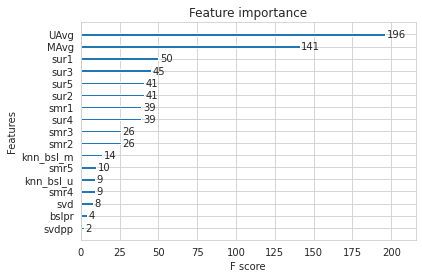

In [ ]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
model_evaluation_train['xgb_final'] = train_results
model_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

<h3> 4.4.8 XgBoost with Surprise Baseline + Surprise KNNbaseline + MF 

---

Techniques(3+4+5+6) </h3>

Training the model
[10:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done...
Timetaken0:00:06.031793...
Evaluating the model with TRAIN data...
Evaluating the test data
Time taken to the test dataset0:00:00.001666

TEST DATA
------------------------------
RMSE :  1.0095543490349246
MAPE :  37.520803809165955


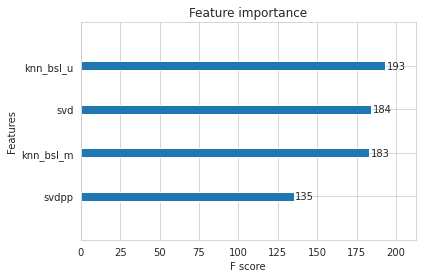

In [ ]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
model_evaluation_train['xgb_all_models'] = train_results
model_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

In [ ]:
reg_train.columns

Index(['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5', 'smr1',
       'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating', 'bslpr',
       'knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp'],
      dtype='object')

In [ ]:
model_evaluation_test['first_algo']

{'rmse': 0.9941416273339712,
 'mape': 36.53556629231102,
 'predictions': array([3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703, 3.503703, 3.503703,
        3.503703, 3.503703, 3.503703, 3.503703], dtype=float32)}

In [ ]:
##storing it into the dataframe
pd.DataFrame(model_evaluation_test).to_csv('/content/drive/MyDrive/netflix files/final_results_test.csv')
models=pd.read_csv('/content/drive/MyDrive/netflix files/final_results_test.csv',index_col=0)
print(models.loc['rmse'].sort_values())
print("#"*50)
print(models.loc['mape'].sort_values())

xgb_knn_bsl        0.992718665374202
xgb_final         0.9936473301015222
first_algo        0.9941416273339712
xgb_all_models    1.0095543490349246
bsl_algo          1.0127958755414286
knn_bsl_u         1.0127958755414286
knn_bsl_m         1.0127958755414286
svdpp_test        1.0127958755414286
svd               1.0127958755414286
xgb_bsl           1.0441717946976472
Name: rmse, dtype: object
##################################################
xgb_knn_bsl         36.4286701616488
xgb_final          36.49885301527224
first_algo         36.53556629231102
xgb_all_models    37.520803809165955
bsl_algo           37.70008017719995
knn_bsl_u          37.70008017719995
knn_bsl_m          37.70008017719995
svdpp_test         37.70008017719995
svd                37.70008017719995
xgb_bsl            39.16842105263157
Name: mape, dtype: object


__FinalTakeaway:
xgb_knn_with baseline_user_movie is the best model for the prediction__

__DEPLOYMENT__:

creating the frontend of the model using streamlit and deploying the model.

In [ ]:
##first we need to get the input 
def recommend(movie):
  movie_id=movie_titles[movie_titles.title==movie].index[0]
  recommended_movie_ids=similar_movie[movie_id]
  recommend_movies_dataframe=movie_titles.loc[recommended_movie_ids]
  #print(recommend_movies)
  for i in recommend_movies_dataframe.title:
    print(i)


In [ ]:
#testing the function along with scratchcode on the right side of the m_m_sim[67]
recommend('Vampire Journals')

Modern Vampires
Subspecies 4: Bloodstorm
To Sleep With a Vampire
Dracula: The Dark Prince
Dracula Rising
Vampires: Los Muertos
Vampirella
Club Vampire
The Breed
Dracula II: Ascension
Scars of Dracula
Kindred: The Embraced: The Complete Vampire Collection
Innocent Blood
She Creature
Blood Moon
Earth vs. The Spider
Captain Kronos: Vampire Hunter
Reign in Darkness
The Locals
The Shiver of the Vampires
Vampires
The Forsaken
The Creeps
Dead and Rotting
Carnosaur
Wishmaster 4: The Prophecy Fulfilled
Scarecrow
Fright Night Part II
Razor Blade Smile
Count Yorga
The Fear
Bram Stoker's Shadowbuilder
Warlock 3: The End of Innocence
Dracula 2000
Phantom of the Opera
From Dusk Till Dawn 2: Texas Blood Money
Wishmaster 3: Beyond The Gates of Hell
Night Flier
Children of the Night
Corpses
Dagon
Howling 3: The Marsupials
Surgeon
Bad Moon
The Eighteenth Angel
Warlock
Frost: Portrait of a Vampire
Blood Ties
From Dusk Till Dawn 3: The Hangman's Daughter
Phantasm IV: Oblivion
Fangs
Sometimes They Come Bac

In [ ]:
import pickle

In [ ]:
pickle.dump(movie_titles,open('movies.pkl','wb'))

In [ ]:
pickle.dump(movie_titles.to_dict(),open('movies_dict.pkl','wb'))

In [ ]:
df=pd.DataFrame(movie_titles.to_dict())

In [ ]:
movie_titles.to_dict()

{'year_of_release': {1: 2003.0,
  2: 2004.0,
  3: 1997.0,
  4: 1994.0,
  5: 2004.0,
  6: 1997.0,
  7: 1992.0,
  8: 2004.0,
  9: 1991.0,
  10: 2001.0,
  11: 1999.0,
  12: 1947.0,
  13: 2003.0,
  14: 1982.0,
  15: 1988.0,
  16: 1996.0,
  17: 2005.0,
  18: 1994.0,
  19: 2000.0,
  20: 1972.0,
  21: 2002.0,
  22: 2000.0,
  23: 2001.0,
  24: 1981.0,
  25: 1997.0,
  26: 2004.0,
  27: 1962.0,
  28: 2002.0,
  29: 2001.0,
  30: 2003.0,
  31: 1999.0,
  32: 2004.0,
  33: 2000.0,
  34: 2003.0,
  35: 2000.0,
  36: 1992.0,
  37: 1973.0,
  38: 2003.0,
  39: 2000.0,
  40: 2004.0,
  41: 2000.0,
  42: 2002.0,
  43: 2000.0,
  44: 1996.0,
  45: 1999.0,
  46: 1964.0,
  47: 1952.0,
  48: 2001.0,
  49: 2003.0,
  50: 1941.0,
  51: 2002.0,
  52: 2002.0,
  53: 2003.0,
  54: 1952.0,
  55: 1995.0,
  56: 2004.0,
  57: 1995.0,
  58: 1996.0,
  59: 2003.0,
  60: 1969.0,
  61: 1999.0,
  62: 1991.0,
  63: 1943.0,
  64: 2001.0,
  65: 2000.0,
  66: 1989.0,
  67: 1997.0,
  68: 2004.0,
  69: 2003.0,
  70: 1999.0,
  71: 1995

In [ ]:
pickle.dump(similar_movie,open('similar_movie.pkl','wb'))

In [ ]:
type(similar_movie)

dict